In [1]:
import os
import time

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
if not os.path.exists('./dae_mnist'):
    os.mkdir('./dae_mnist')

In [3]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.4
    noisy_img = img + noise
    return noisy_img

def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

def tensor_round(tensor):
    return torch.round(tensor)

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])

In [5]:
dataset = MNIST('', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [6]:
for data in dataloader:
    break;
data[0].shape[0]

128

Label: 4


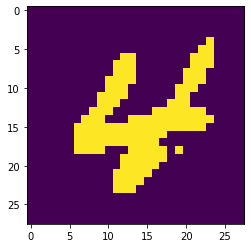

In [7]:
i = 30
plt.imshow(data[0][i].view((28, 28)))
print(f'Label: {data[1][i]}')

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on the GPU')
else:
    device = torch.device('cpu')
    print('running on the CPU')

running on the GPU


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-5)

In [15]:
MODEL_NAME = f'model-{int(time.time())}'
print(MODEL_NAME)
num_epochs = 100

for epoch in range(num_epochs):
    with open(f'dae_mnist_{MODEL_NAME}.log', 'a') as f:
        for data in tqdm(dataloader, position=0, leave=True):
            img, _ = data
            img = img.view(img.size(0), -1)
            noisy_img = add_noise(img)
            noisy_img = Variable(noisy_img).cuda()
            img = Variable(img).cuda()
            
            # ===================forward=====================
            output = model(noisy_img)
            loss = criterion(output, img)
            MSE_loss = nn.MSELoss()(output, img)
            
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # ===================log========================        
        print(f'epoch [{epoch+1}/{num_epochs}], '\
              f'loss:{loss.data.item():.4f}, MSE_loss:{MSE_loss.data.item():.4f}')
        f.write(f'{epoch+1},{round(time.time(), 3)},'\
                f'{loss.data.item():.4f},{MSE_loss.data.item():.4f}\n')
        
    if epoch % 5 == 0:
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        x_noisy = to_img(noisy_img.cpu().data)
        weights = to_img(model.encoder[0].weight.cpu().data)
        save_image(x, f'./dae_mnist/x_{epoch}.png')
        save_image(x_noisy, f'./dae_mnist/x_noisy_{epoch}.png')
        save_image(x_hat, f'./dae_mnist/x_hat_{epoch}.png')
        save_image(weights, f'./dae_mnist/weights_epoch_{epoch}.png')
        
torch.save(model.state_dict(), f'./dae_minist_{MODEL_NAME}_statedict.pth')

  1%|          | 4/469 [00:00<00:13, 35.56it/s]

model-1595576883


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [1/100], loss:0.1029, MSE_loss:0.0315


  1%|          | 5/469 [00:00<00:10, 43.47it/s]

epoch [2/100], loss:0.0897, MSE_loss:0.0276


  1%|          | 5/469 [00:00<00:10, 43.03it/s]

epoch [3/100], loss:0.0896, MSE_loss:0.0273


  1%|          | 5/469 [00:00<00:11, 42.16it/s]

epoch [4/100], loss:0.0870, MSE_loss:0.0267


  1%|          | 5/469 [00:00<00:10, 42.36it/s]

epoch [5/100], loss:0.0778, MSE_loss:0.0235


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [6/100], loss:0.0793, MSE_loss:0.0240


  1%|          | 5/469 [00:00<00:10, 43.21it/s]

epoch [7/100], loss:0.0774, MSE_loss:0.0236


  1%|          | 5/469 [00:00<00:10, 44.18it/s]

epoch [8/100], loss:0.0755, MSE_loss:0.0230


  1%|          | 5/469 [00:00<00:11, 41.98it/s]

epoch [9/100], loss:0.0725, MSE_loss:0.0219


  1%|          | 5/469 [00:00<00:10, 43.87it/s]

epoch [10/100], loss:0.0723, MSE_loss:0.0220


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [11/100], loss:0.0722, MSE_loss:0.0219


  1%|          | 5/469 [00:00<00:10, 42.51it/s]

epoch [12/100], loss:0.0724, MSE_loss:0.0219


  1%|          | 5/469 [00:00<00:10, 42.67it/s]

epoch [13/100], loss:0.0687, MSE_loss:0.0209


  1%|          | 5/469 [00:00<00:10, 42.37it/s]

epoch [14/100], loss:0.0735, MSE_loss:0.0223


  1%|          | 5/469 [00:00<00:10, 43.27it/s]

epoch [15/100], loss:0.0639, MSE_loss:0.0193


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [16/100], loss:0.0665, MSE_loss:0.0201


  1%|          | 5/469 [00:00<00:11, 41.99it/s]

epoch [17/100], loss:0.0668, MSE_loss:0.0204


  1%|          | 5/469 [00:00<00:11, 41.77it/s]

epoch [18/100], loss:0.0652, MSE_loss:0.0198


  1%|          | 5/469 [00:00<00:10, 43.85it/s]

epoch [19/100], loss:0.0689, MSE_loss:0.0208


  1%|          | 4/469 [00:00<00:12, 38.62it/s]

epoch [20/100], loss:0.0699, MSE_loss:0.0210


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [21/100], loss:0.0644, MSE_loss:0.0196


  1%|          | 4/469 [00:00<00:12, 37.29it/s]

epoch [22/100], loss:0.0685, MSE_loss:0.0207


  1%|          | 5/469 [00:00<00:11, 41.05it/s]

epoch [23/100], loss:0.0663, MSE_loss:0.0201


  1%|          | 5/469 [00:00<00:10, 42.31it/s]

epoch [24/100], loss:0.0629, MSE_loss:0.0189


  1%|          | 5/469 [00:00<00:10, 43.89it/s]

epoch [25/100], loss:0.0616, MSE_loss:0.0184


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [26/100], loss:0.0667, MSE_loss:0.0200


  1%|          | 5/469 [00:00<00:11, 41.91it/s]

epoch [27/100], loss:0.0707, MSE_loss:0.0212


  1%|          | 5/469 [00:00<00:11, 40.90it/s]

epoch [28/100], loss:0.0676, MSE_loss:0.0204


  1%|          | 4/469 [00:00<00:14, 32.80it/s]

epoch [29/100], loss:0.0688, MSE_loss:0.0208


  1%|          | 5/469 [00:00<00:10, 45.23it/s]

epoch [30/100], loss:0.0669, MSE_loss:0.0201


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [31/100], loss:0.0651, MSE_loss:0.0197


  1%|          | 4/469 [00:00<00:12, 36.21it/s]

epoch [32/100], loss:0.0658, MSE_loss:0.0197


  1%|          | 5/469 [00:00<00:10, 42.57it/s]

epoch [33/100], loss:0.0623, MSE_loss:0.0188


  1%|          | 4/469 [00:00<00:12, 37.23it/s]

epoch [34/100], loss:0.0621, MSE_loss:0.0187


  1%|          | 5/469 [00:00<00:10, 42.80it/s]

epoch [35/100], loss:0.0635, MSE_loss:0.0189


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [36/100], loss:0.0680, MSE_loss:0.0205


  1%|          | 4/469 [00:00<00:12, 37.95it/s]

epoch [37/100], loss:0.0636, MSE_loss:0.0191


  1%|          | 4/469 [00:00<00:11, 39.58it/s]

epoch [38/100], loss:0.0650, MSE_loss:0.0195


  1%|          | 4/469 [00:00<00:12, 37.69it/s]

epoch [39/100], loss:0.0621, MSE_loss:0.0185


  1%|          | 4/469 [00:00<00:12, 36.22it/s]

epoch [40/100], loss:0.0631, MSE_loss:0.0191


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [41/100], loss:0.0666, MSE_loss:0.0200


  1%|          | 5/469 [00:00<00:10, 44.61it/s]

epoch [42/100], loss:0.0647, MSE_loss:0.0194


  1%|          | 4/469 [00:00<00:13, 34.55it/s]

epoch [43/100], loss:0.0623, MSE_loss:0.0187


  1%|          | 4/469 [00:00<00:11, 39.97it/s]

epoch [44/100], loss:0.0656, MSE_loss:0.0196


  1%|          | 5/469 [00:00<00:11, 41.20it/s]

epoch [45/100], loss:0.0670, MSE_loss:0.0201


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [46/100], loss:0.0636, MSE_loss:0.0188


  1%|          | 4/469 [00:00<00:12, 35.81it/s]

epoch [47/100], loss:0.0619, MSE_loss:0.0185


  1%|          | 4/469 [00:00<00:11, 39.14it/s]

epoch [48/100], loss:0.0627, MSE_loss:0.0189


  1%|          | 4/469 [00:00<00:12, 35.81it/s]

epoch [49/100], loss:0.0633, MSE_loss:0.0190


  1%|          | 5/469 [00:00<00:11, 41.63it/s]

epoch [50/100], loss:0.0638, MSE_loss:0.0191


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [51/100], loss:0.0629, MSE_loss:0.0188


  1%|          | 4/469 [00:00<00:11, 40.00it/s]

epoch [52/100], loss:0.0597, MSE_loss:0.0180


  1%|          | 5/469 [00:00<00:11, 42.06it/s]

epoch [53/100], loss:0.0612, MSE_loss:0.0186


  1%|          | 5/469 [00:00<00:11, 41.65it/s]

epoch [54/100], loss:0.0650, MSE_loss:0.0196


  1%|          | 4/469 [00:00<00:11, 39.47it/s]

epoch [55/100], loss:0.0620, MSE_loss:0.0187


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [56/100], loss:0.0611, MSE_loss:0.0185


  1%|          | 4/469 [00:00<00:13, 34.26it/s]

epoch [57/100], loss:0.0608, MSE_loss:0.0183


  1%|          | 4/469 [00:00<00:12, 36.24it/s]

epoch [58/100], loss:0.0630, MSE_loss:0.0189


  1%|          | 4/469 [00:00<00:11, 39.77it/s]

epoch [59/100], loss:0.0578, MSE_loss:0.0172


  1%|          | 5/469 [00:00<00:10, 42.37it/s]

epoch [60/100], loss:0.0668, MSE_loss:0.0201


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [61/100], loss:0.0587, MSE_loss:0.0176


  1%|          | 5/469 [00:00<00:11, 41.15it/s]

epoch [62/100], loss:0.0661, MSE_loss:0.0199


  1%|          | 4/469 [00:00<00:13, 35.00it/s]

epoch [63/100], loss:0.0636, MSE_loss:0.0189


  1%|          | 5/469 [00:00<00:11, 41.46it/s]

epoch [64/100], loss:0.0652, MSE_loss:0.0196


  1%|          | 4/469 [00:00<00:12, 36.73it/s]

epoch [65/100], loss:0.0581, MSE_loss:0.0172


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [66/100], loss:0.0641, MSE_loss:0.0194


  1%|          | 4/469 [00:00<00:12, 36.29it/s]

epoch [67/100], loss:0.0610, MSE_loss:0.0181


  1%|          | 4/469 [00:00<00:12, 36.22it/s]

epoch [68/100], loss:0.0612, MSE_loss:0.0185


  1%|          | 5/469 [00:00<00:11, 41.72it/s]

epoch [69/100], loss:0.0639, MSE_loss:0.0192


  1%|          | 4/469 [00:00<00:14, 31.77it/s]

epoch [70/100], loss:0.0600, MSE_loss:0.0179


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [71/100], loss:0.0620, MSE_loss:0.0187


  1%|          | 4/469 [00:00<00:12, 38.31it/s]

epoch [72/100], loss:0.0560, MSE_loss:0.0166


  1%|          | 4/469 [00:00<00:12, 37.92it/s]

epoch [73/100], loss:0.0662, MSE_loss:0.0200


  1%|          | 4/469 [00:00<00:11, 38.83it/s]

epoch [74/100], loss:0.0618, MSE_loss:0.0184


  1%|          | 4/469 [00:00<00:11, 39.01it/s]

epoch [75/100], loss:0.0636, MSE_loss:0.0192


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [76/100], loss:0.0611, MSE_loss:0.0185


  1%|          | 5/469 [00:00<00:10, 42.80it/s]

epoch [77/100], loss:0.0618, MSE_loss:0.0186


  1%|          | 4/469 [00:00<00:13, 34.50it/s]

epoch [78/100], loss:0.0617, MSE_loss:0.0184


  1%|          | 5/469 [00:00<00:11, 41.05it/s]

epoch [79/100], loss:0.0575, MSE_loss:0.0174


  1%|          | 4/469 [00:00<00:14, 32.49it/s]

epoch [80/100], loss:0.0601, MSE_loss:0.0179


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [81/100], loss:0.0584, MSE_loss:0.0175


  1%|          | 4/469 [00:00<00:12, 36.21it/s]

epoch [82/100], loss:0.0601, MSE_loss:0.0182


  1%|          | 4/469 [00:00<00:13, 35.37it/s]

epoch [83/100], loss:0.0584, MSE_loss:0.0175


  1%|          | 4/469 [00:00<00:12, 37.33it/s]

epoch [84/100], loss:0.0598, MSE_loss:0.0180


  1%|          | 5/469 [00:00<00:10, 43.45it/s]

epoch [85/100], loss:0.0631, MSE_loss:0.0190


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [86/100], loss:0.0598, MSE_loss:0.0179


  1%|          | 5/469 [00:00<00:11, 40.87it/s]

epoch [87/100], loss:0.0624, MSE_loss:0.0187


  1%|          | 4/469 [00:00<00:12, 35.96it/s]

epoch [88/100], loss:0.0602, MSE_loss:0.0182


  1%|          | 5/469 [00:00<00:11, 41.35it/s]

epoch [89/100], loss:0.0624, MSE_loss:0.0187


  1%|          | 4/469 [00:00<00:14, 31.83it/s]

epoch [90/100], loss:0.0606, MSE_loss:0.0184


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [91/100], loss:0.0576, MSE_loss:0.0173


  1%|          | 5/469 [00:00<00:10, 42.99it/s]

epoch [92/100], loss:0.0589, MSE_loss:0.0177


  1%|          | 4/469 [00:00<00:12, 37.05it/s]

epoch [93/100], loss:0.0532, MSE_loss:0.0159


  1%|          | 5/469 [00:00<00:11, 41.00it/s]

epoch [94/100], loss:0.0609, MSE_loss:0.0183


  1%|          | 4/469 [00:00<00:13, 34.13it/s]

epoch [95/100], loss:0.0599, MSE_loss:0.0181


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [96/100], loss:0.0628, MSE_loss:0.0190


  1%|          | 5/469 [00:00<00:10, 42.71it/s]

epoch [97/100], loss:0.0614, MSE_loss:0.0184


  1%|          | 5/469 [00:00<00:11, 41.94it/s]

epoch [98/100], loss:0.0621, MSE_loss:0.0187


  1%|          | 5/469 [00:00<00:10, 42.90it/s]

epoch [99/100], loss:0.0591, MSE_loss:0.0178


100%|██████████| 469/469 [00:10<00:00, 43.35it/s]

epoch [100/100], loss:0.0594, MSE_loss:0.0177
